# **Phase 1: Training Without Data Augmentation (Baseline Model)**


## 📥 Step 1: Dataset Setup and Preparation

In this step, we import all necessary libraries and download our cleaned waste classification dataset from Kaggle using `kagglehub`. We extract the image paths and corresponding labels, store them in a Pandas DataFrame, and split the data into training and validation sets with stratified sampling to preserve class distribution.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

# Download and set up the dataset path
print("Downloading dataset...")
path = kagglehub.dataset_download("raniastudentlitim/cleaned-dataset")
dataset_path = str(path)
print("Path to dataset files:", dataset_path)

# Create a DataFrame from image files
filepaths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        # Check for common image extensions
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(dirname, filename))
            labels.append(os.path.basename(dirname))

# Create DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"\nFound {len(data_df)} images in {len(data_df['label'].unique())} classes.")

# Split into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['label']
)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

2025-07-11 23:02:07.327429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752274927.567048      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752274927.644858      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to dataset files: /kaggle/input/cleaned-dataset

Found 35948 images in 9 classes.
Training samples: 28758
Validation samples: 7190


## 🔄 Step 2: Data Generators for Model Input

In this step, we prepare the image data for training and validation using TensorFlow's `ImageDataGenerator`. We rescale pixel values to normalize the input between 0 and 1. At this stage, no data augmentation is applied. The images are loaded from the file paths defined in the previous step and resized to 224×224 pixels, with labels encoded in categorical format.


In [3]:
# Get class indices and labels
class_indices = train_generator_no_aug.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
training_labels = train_df['label']

# Compute class weights
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_labels),
    y=training_labels
)
class_weights_dict = {class_indices[label]: weight for label, weight in zip(np.unique(training_labels), class_weights_raw)}

print("✅ Final class_weights_dict (index → weight):\n")
for idx, weight in class_weights_dict.items():
    print(f"Class {idx:2d} ({index_to_label[idx]:17s}): {weight:.2f}")

✅ Final class_weights_dict (index → weight):

Class  0 (Cardboard        ): 1.46
Class  1 (Electronic Waste ): 4.23
Class  2 (General Waste    ): 1.42
Class  3 (Glass            ): 0.61
Class  4 (Metals           ): 1.16
Class  5 (Organic Waste    ): 4.00
Class  6 (Paper            ): 0.97
Class  7 (Plastics         ): 0.84
Class  8 (Textiles         ): 0.42



### 🔍 Inference:
- Classes like **Electronic Waste** and **Organic Waste** are underrepresented, receiving **high weights** (>4) to help the model focus more on them during training.
- In contrast, **Textiles** and **Glass** are overrepresented, leading to lower weights (<0.7).
- Using these class weights helps the model to **reduce bias** toward dominant classes and improves performance across all categories.


## 🧠 Step 3: Model Construction and Initial Training (Without Augmentation)

In this step, we load the **EfficientNetV2B0** model pretrained on ImageNet, excluding its top classification layer. The base model is **frozen** to retain the learned visual features and avoid updating its weights during initial training.

We build a custom classification head composed of:
- `GlobalAveragePooling2D` to reduce the spatial dimensions,
- A `Dense` output layer with softmax activation to predict the class probabilities.

The model is compiled using:
- **Adam optimizer** with a learning rate of 1e-3,
- **Categorical cross-entropy** as the loss function,
- **Accuracy** as the evaluation metric.

Finally, we train the model for **15 epochs** using the unaugmented training data and apply the computed **class weights** to reduce bias due to class imbalance.


In [4]:
# Load the base model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # Freeze base model

# Build the full model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(class_indices), activation='softmax')(x)
model_no_aug = Model(inputs, outputs)

# Compile the model
model_no_aug.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("\n--- Starting Training (Without Augmentation) ---")
history_no_aug = model_no_aug.fit(
    train_generator_no_aug,
    epochs=15,
    validation_data=val_generator,
    class_weight=class_weights_dict
)

I0000 00:00:1752276130.906154      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752276130.906854      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Training (Without Augmentation) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1752276151.673876     102 service.cc:148] XLA service 0x7a2e541128e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752276151.674730     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752276151.674753     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752276153.662061     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/899 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.0547 - loss: 2.5692   

I0000 00:00:1752276164.366974     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


899/899 ━━━━━━━━━━━━━━━━━━━━ 178s 165ms/step - accuracy: 0.0926 - loss: 2.2300 - val_accuracy: 0.0924 - val_loss: 2.1737
Epoch 2/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.1007 - loss: 2.2105 - val_accuracy: 0.1129 - val_loss: 2.1096
Epoch 3/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step - accuracy: 0.1112 - loss: 2.1941 - val_accuracy: 0.1477 - val_loss: 2.1745
Epoch 4/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.1050 - loss: 2.1856 - val_accuracy: 0.0705 - val_loss: 2.2395
Epoch 5/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - accuracy: 0.1102 - loss: 2.1947 - val_accuracy: 0.1161 - val_loss: 2.1583
Epoch 6/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.1116 - loss: 2.1867 - val_accuracy: 0.1246 - val_loss: 2.1921
Epoch 7/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.1150 - loss: 2.1656 - val_accuracy: 0.0764 - val_loss: 2.2521
Epoch 8/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.1251 - loss: 2.1562 - val_accur

## 📊 Step 4: Evaluation of Baseline Model (Without Augmentation)

After training the model without any data augmentation, we evaluate its performance on the validation set.

- **Predictions** are generated for all validation images.
- We compute a **classification report**, which includes precision, recall, and F1-score for each class.
- We also visualize the results using a **confusion matrix** to better understand the model’s strengths and weaknesses in classifying different types of waste.

This evaluation serves as a baseline to compare with future models trained with data augmentation and fine-tuning.



--- Evaluating Baseline Model (Without Augmentation) ---
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step

Classification Report:

                  precision    recall  f1-score   support

       Cardboard       0.00      0.00      0.00       549
Electronic Waste       0.10      0.24      0.14       189
   General Waste       0.00      0.00      0.00       562
           Glass       0.42      0.01      0.01      1306
          Metals       0.00      0.00      0.00       686
   Organic Waste       0.04      0.51      0.08       199
           Paper       0.00      0.00      0.00       824
        Plastics       0.18      0.80      0.29       951
        Textiles       0.12      0.00      0.00      1924

        accuracy                           0.13      7190
       macro avg       0.10      0.17      0.06      7190
    weighted avg       0.14      0.13      0.05      7190



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


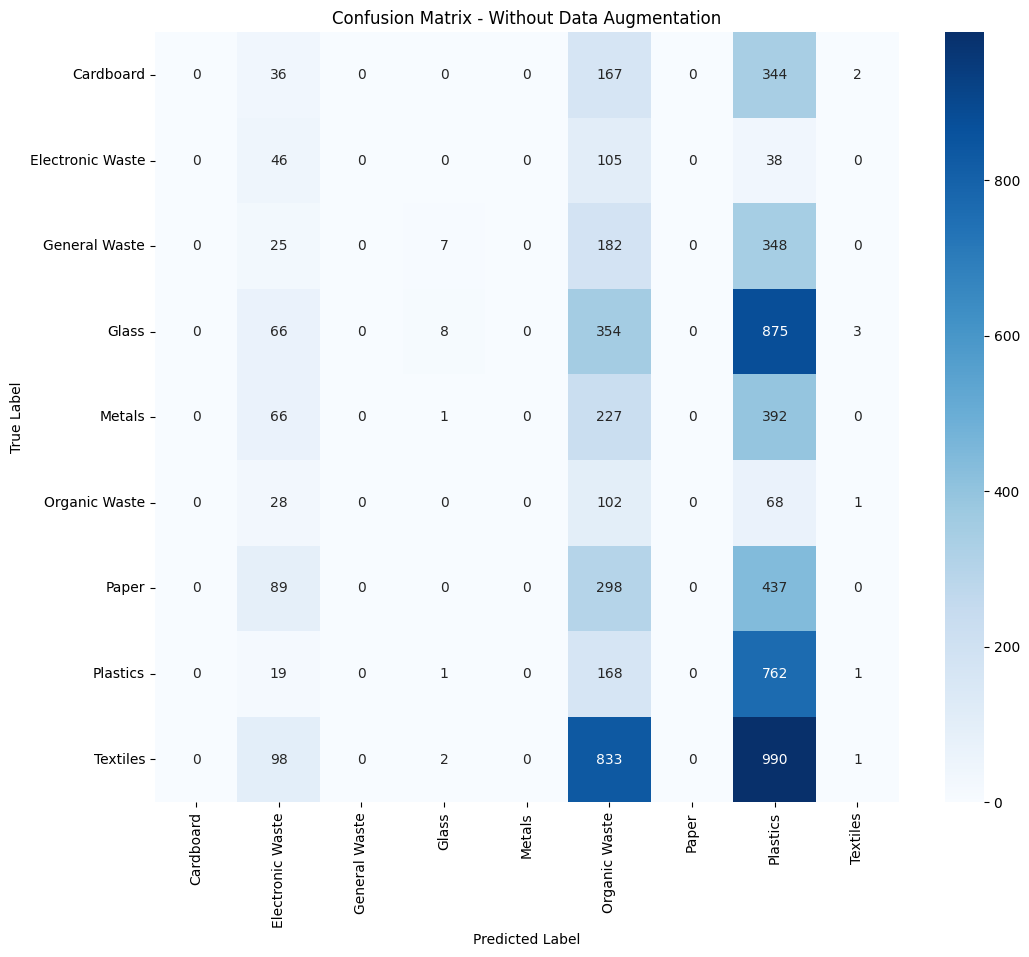

In [6]:
print("\n--- Evaluating Baseline Model (Without Augmentation) ---")

# Generate predictions
Y_pred = model_no_aug.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_indices.keys()), yticklabels=list(class_indices.keys()))
plt.title('Confusion Matrix - Without Data Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

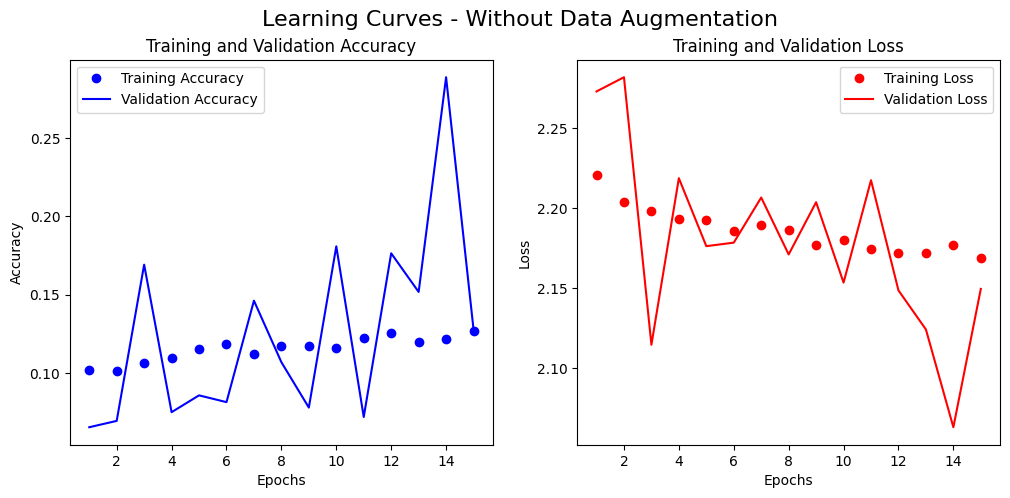

In [7]:
# --- Enhanced Evaluation Code ---

import matplotlib.pyplot as plt

# Retrieve history from training
history_dict = history_no_aug.history

# Get training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create an array for the number of epochs
epochs = range(1, len(acc) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Learning Curves ', fontsize=16)
plt.show()


--- Detailed Evaluation Metrics ---
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step
Overall Validation Accuracy: 0.1278

Classification Report:

                  precision    recall  f1-score   support

       Cardboard     0.0000    0.0000    0.0000       549
Electronic Waste     0.0973    0.2434    0.1390       189
   General Waste     0.0000    0.0000    0.0000       562
           Glass     0.4211    0.0061    0.0121      1306
          Metals     0.0000    0.0000    0.0000       686
   Organic Waste     0.0419    0.5126    0.0774       199
           Paper     0.0000    0.0000    0.0000       824
        Plastics     0.1791    0.8013    0.2928       951
        Textiles     0.1250    0.0005    0.0010      1924

        accuracy                         0.1278      7190
       macro avg     0.0960    0.1738    0.0580      7190
    weighted avg     0.1373    0.1278    0.0470      7190


--- F1-Scores ---
F1-Score for class 'Cardboard': 0.0000
F1-Score for class 'Electronic Waste': 0.139

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

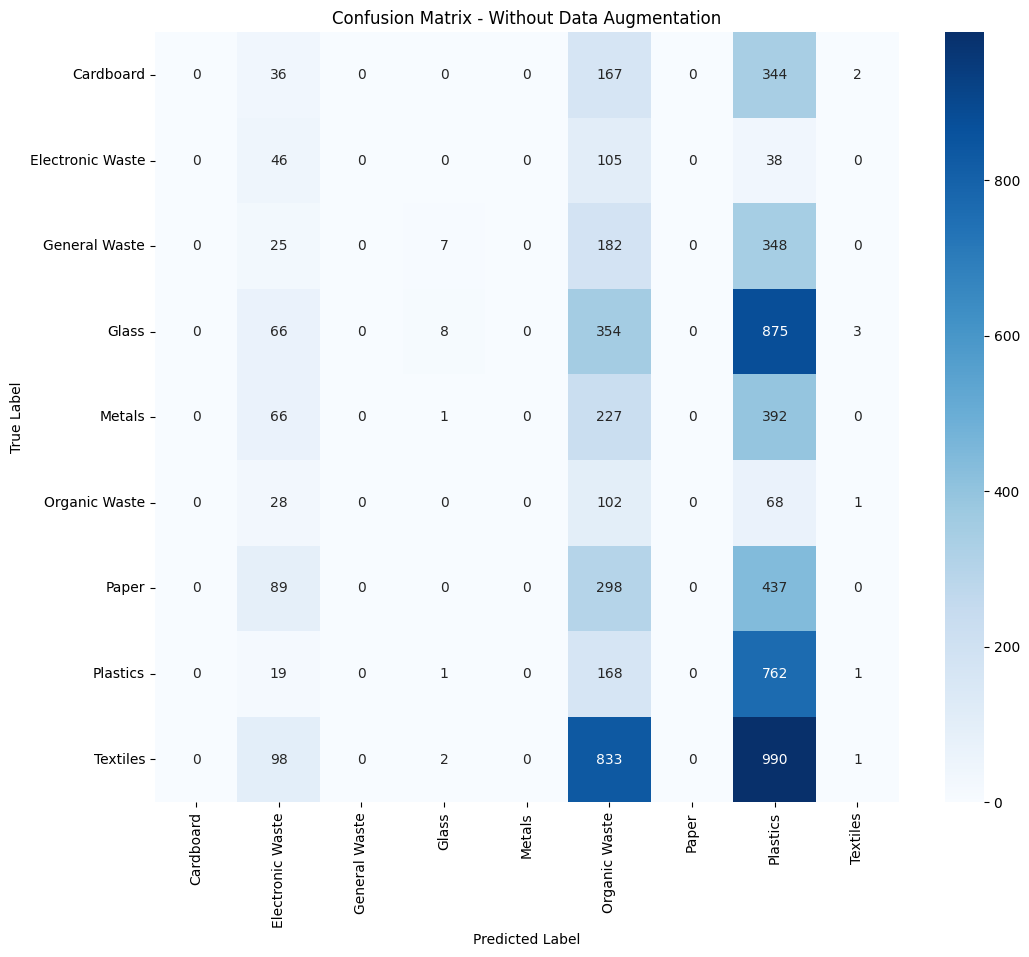

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Predictions and Metrics Code ---

print("\n--- Detailed Evaluation Metrics ---")

# Predict on the validation generator
# Note: Ensure the generator is NOT shuffled for evaluation
val_generator.reset() # Reset generator to be safe
Y_pred = model_no_aug.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 1. Calculate and Print Overall Accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Validation Accuracy: {overall_accuracy:.4f}\n")

# 2. Generate and Print the Classification Report
# The 'digits=4' argument gives more precision
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("Classification Report:\n")
print(report)

# You can also get the report as a dictionary to access specific values
report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Example: Print the F1-score for each class and the weighted average
print("\n--- F1-Scores ---")
for class_name, metrics in report_dict.items():
    if isinstance(metrics, dict):
        print(f"F1-Score for class '{class_name}': {metrics['f1-score']:.4f}")

# The weighted average F1-score is a key metric for the overall model
weighted_f1 = report_dict['weighted avg']['f1-score']
print(f"\nWeighted Average F1-Score: {weighted_f1:.4f}")

# 3. Plot the Confusion Matrix (as before, for visual inspection)
print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Without Data Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

well the results are catastrophic, lets move to the other phase and see if  there is an improvement 

### 📉 Inference: Baseline Model Performance (Without Augmentation)

The baseline model, trained without data augmentation and using a frozen EfficientNetV2B0 backbone, yields poor performance on the validation set.

#### 🔎 Key Observations:

- **Very low overall accuracy**: Only **13%** of the validation samples were correctly classified.
- **Class imbalance impact**: Some dominant classes like **Plastics** show relatively better recall (0.80), while others like **Textiles** and **General Waste** are barely detected.
- **Zero precision and recall** for several classes (e.g., Cardboard, Metals, Paper), indicating that the model is not learning to distinguish these classes at all.
- The **macro average F1-score is only 0.06**, confirming the poor performance across most classes.
- Despite using class weights during training, the model heavily favors a few classes and struggles with underrepresented or visually similar categories.

#### ⚠️ Conclusion:
This initial result highlights the limitations of training on raw, unaugmented data. To improve generalization and class sensitivity, we need to:
- Introduce **data augmentation** to increase variation in training samples.
- Consider **fine-tuning** the EfficientNet layers.
- Further analyze data distribution and class similarities.

This baseline sets a useful performance floor for comparison with future improvements.


# **Phase 2: Training With Your Designed Data Augmentation**

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure you still have these from Phase 1 ---
# train_df, val_df, class_weights_dict, val_generator

print("--- Phase 2: Training with Advanced Data Augmentation ---")

# 1. Define the generator with your specified transformations
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,                 # Rescaling (Necessary)
    rotation_range=30,              # Rotation
    width_shift_range=0.2,          # Width Shift
    height_shift_range=0.2,         # Height Shift
    shear_range=0.2,                # Shear
    zoom_range=0.2,                 # Zoom
    horizontal_flip=True,           # Horizontal Flip
    brightness_range=[0.8, 1.2],    # Brightness Adjustment
    channel_shift_range=20.0,       # Channel Shift
    fill_mode='nearest'             # Fill Mode
)

# 2. Create the new training generator
# Note: We re-use the train_df DataFrame from the initial split
train_generator_with_aug = train_datagen_with_aug.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

# The validation generator from Phase 1 remains the same (no augmentation)
print("\nValidation generator is ready.")
print("New augmented training generator is ready.")

--- Phase 2: Training with Advanced Data Augmentation ---
Found 28758 validated image filenames belonging to 9 classes.

Validation generator is ready.
New augmented training generator is ready.


In [10]:
# 3. Build a completely new model instance
base_model_aug = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_aug.trainable = False  # Keep the base frozen initially

inputs_aug = tf.keras.Input(shape=(224, 224, 3))
x_aug = base_model_aug(inputs_aug, training=False)
x_aug = GlobalAveragePooling2D()(x_aug)
x_aug = tf.keras.layers.Dropout(0.3)(x_aug) # Adding dropout as another regularization layer
outputs_aug = Dense(len(class_weights_dict), activation='softmax')(x_aug)
model_with_aug = Model(inputs_aug, outputs_aug)

# 4. Compile the new model
model_with_aug.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_with_aug.summary()

# 5. Train the model
# Because augmentation makes the training task harder and helps prevent overfitting,
# we can often train for more epochs.
print("\n--- Starting Training on Augmented Data ---")
history_with_aug = model_with_aug.fit(
    train_generator_with_aug,
    epochs=25,  # Increased epochs from 15 to 25
    validation_data=val_generator,
    class_weight=class_weights_dict # Class weights are still very important!
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,930,841 (22.62 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)


--- Starting Training on Augmented Data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 453s 474ms/step - accuracy: 0.0980 - loss: 2.2610 - val_accuracy: 0.2453 - val_loss: 2.0944
Epoch 2/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 399s 443ms/step - accuracy: 0.1027 - loss: 2.2168 - val_accuracy: 0.1174 - val_loss: 2.2552
Epoch 3/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 402s 447ms/step - accuracy: 0.1005 - loss: 2.2186 - val_accuracy: 0.0263 - val_loss: 2.2148
Epoch 4/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 402s 447ms/step - accuracy: 0.0975 - loss: 2.2340 - val_accuracy: 0.1310 - val_loss: 2.2282
Epoch 5/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 406s 452ms/step - accuracy: 0.1009 - loss: 2.2212 - val_accuracy: 0.1328 - val_loss: 2.2660
Epoch 6/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 405s 451ms/step - accuracy: 0.1111 - loss: 2.2128 - val_accuracy: 0.1330 - val_loss: 2.1518
Epoch 7/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 398s 443ms/step - accuracy: 0.1023 - loss: 2.2319 - val_accuracy: 0.1993 - val_loss: 2.1900
Epoch 8/25
899/899 ━━━━━━━━━━━━━━━━━━━━ 408s 454ms/step - accuracy: 0.1023 -


--- Evaluating Final Model (With Augmentation) ---
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 82ms/step
Overall Validation Accuracy (With Augmentation): 0.1001
Baseline Accuracy (Without Augmentation): 0.1278

Classification Report (With Augmentation):

                  precision    recall  f1-score   support

       Cardboard     0.0862    0.4809    0.1463       549
Electronic Waste     0.1117    0.1058    0.1087       189
   General Waste     0.0000    0.0000    0.0000       562
           Glass     0.0000    0.0000    0.0000      1306
          Metals     0.0000    0.0000    0.0000       686
   Organic Waste     0.0000    0.0000    0.0000       199
           Paper     0.1104    0.5291    0.1827       824
        Plastics     0.0000    0.0000    0.0000       951
        Textiles     0.0000    0.0000    0.0000      1924

        accuracy                         0.1001      7190
       macro avg     0.0343    0.1240    0.0486      7190
    weighted avg     0.0222    0.1001    0.0350      7190

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


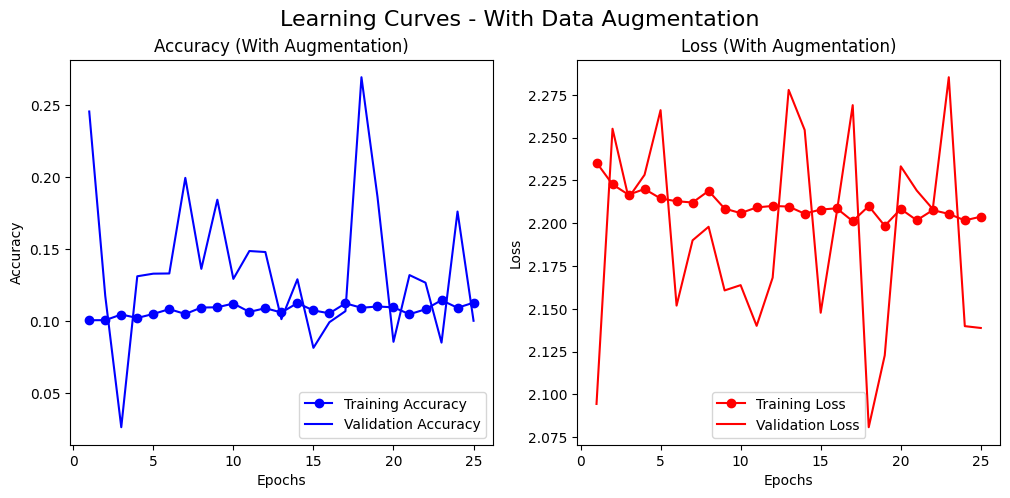


--- Confusion Matrix (With Augmentation) ---


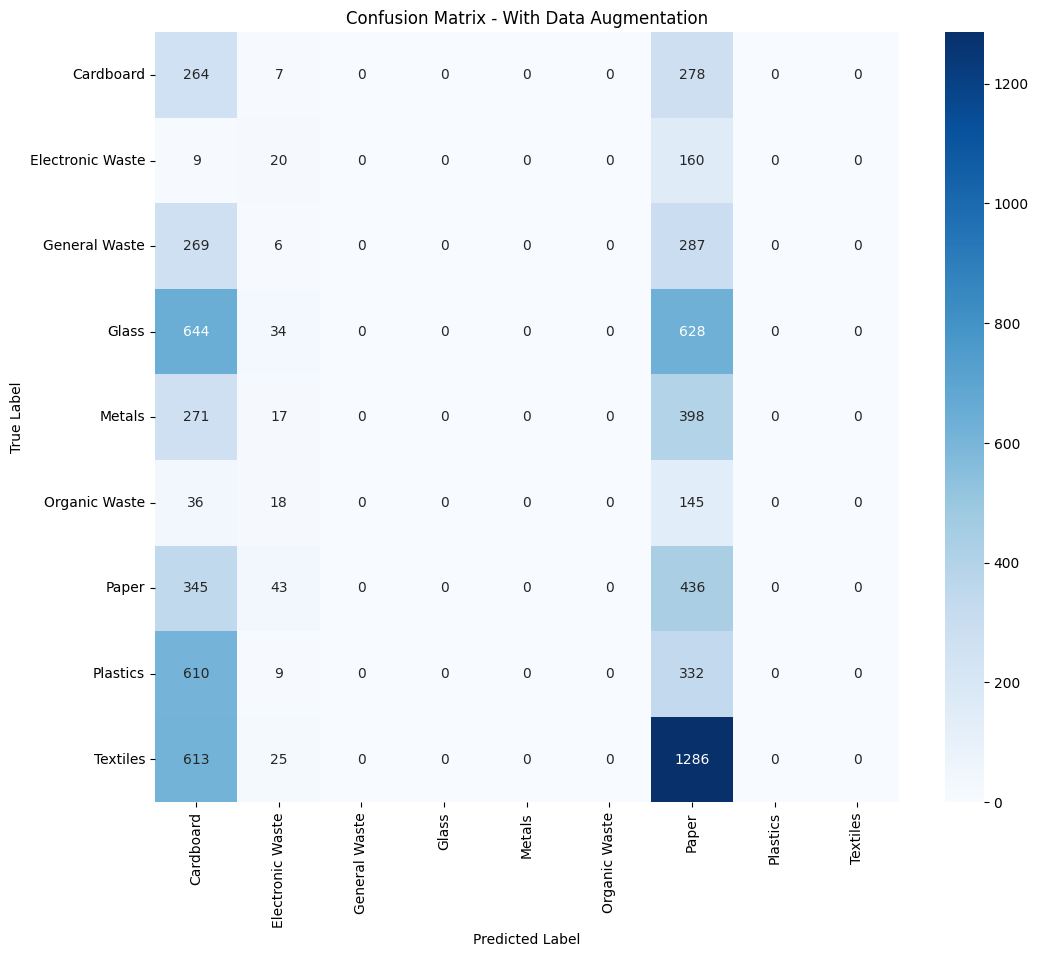

In [11]:
# --- Full Evaluation of the Augmented Model ---

print("\n--- Evaluating Final Model (With Augmentation) ---")

# 6. Predict on the validation set
val_generator.reset()
Y_pred_aug = model_with_aug.predict(val_generator)
y_pred_aug = np.argmax(Y_pred_aug, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 7. Calculate and Print Overall Accuracy
overall_accuracy_aug = accuracy_score(y_true, y_pred_aug)
print(f"Overall Validation Accuracy (With Augmentation): {overall_accuracy_aug:.4f}")
print("Baseline Accuracy (Without Augmentation): 0.1278\n")


# 8. Generate and Print the Classification Report
print("Classification Report (With Augmentation):\n")
report_aug = classification_report(y_true, y_pred_aug, target_names=class_labels, digits=4)
print(report_aug)

# 9. Plot the new Learning Curves
history_dict_aug = history_with_aug.history
acc_aug = history_dict_aug['accuracy']
val_acc_aug = history_dict_aug['val_accuracy']
loss_aug = history_dict_aug['loss']
val_loss_aug = history_dict_aug['val_loss']
epochs_aug = range(1, len(acc_aug) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_aug, acc_aug, 'bo-', label='Training Accuracy')
plt.plot(epochs_aug, val_acc_aug, 'b-', label='Validation Accuracy')
plt.title('Accuracy (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_aug, loss_aug, 'ro-', label='Training Loss')
plt.plot(epochs_aug, val_loss_aug, 'r-', label='Validation Loss')
plt.title('Loss (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.suptitle('Learning Curves - With Data Augmentation', fontsize=16)
plt.show()


# 10. Plot the new Confusion Matrix
print("\n--- Confusion Matrix (With Augmentation) ---")
conf_matrix_aug = confusion_matrix(y_true, y_pred_aug)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - With Data Augmentation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# ==============================================================================
# 1. SETUP AND DATA PREPARATION
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

# Download and set up the dataset path
print("Downloading dataset...")
path = kagglehub.dataset_download("raniastudentlitim/cleaned-dataset")
dataset_path = str(path)
print("Path to dataset files:", dataset_path)

# Create a DataFrame from image files
filepaths = []
labels = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(dirname, filename))
            labels.append(os.path.basename(dirname))

data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"\nFound {len(data_df)} images in {len(data_df['label'].unique())} classes.")

# Split into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.2,
    random_state=42,
    stratify=data_df['label']
)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# ==============================================================================
# 2. DATA AUGMENTATION AND GENERATORS
# ==============================================================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define a powerful data augmentation generator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# The validation generator should NOT have augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ==============================================================================
# 3. CLASS WEIGHT CALCULATION
# ==============================================================================
class_indices = train_generator.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
training_labels = train_df['label']

class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_labels),
    y=training_labels
)
class_weights_dict = {class_indices[label]: weight for label, weight in zip(np.unique(training_labels), class_weights_raw)}

print("\n✅ Final class_weights_dict (index → weight):\n")
for idx, weight in class_weights_dict.items():
    print(f"Class {idx:2d} ({index_to_label[idx]:17s}): {weight:.2f}")

# ==============================================================================
# 4. STAGE 1: INITIAL TRAINING (TRANSFER LEARNING)
# ==============================================================================
print("\n--- Building Model for Stage 1 ---")
# Load the base model with pre-trained ImageNet weights
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# Freeze the base model
# Its weights will not be updated during this first stage
base_model.trainable = False

# Build the full model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False) # Run in inference mode
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x) # Add dropout for regularization
outputs = Dense(len(class_indices), activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model with a standard learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Stage 1: Initial Training ---")
history_initial = model.fit(
    train_generator,
    epochs=15, # Train for 15 epochs in the first stage
    validation_data=val_generator,
    class_weight=class_weights_dict
)

# ==============================================================================
# 5. STAGE 2: FINE-TUNING
# ==============================================================================
print("\n--- Preparing for Stage 2: Fine-Tuning ---")

# Unfreeze the base model to make it trainable
base_model.trainable = True

# Re-compile the model with a very low learning rate. This is CRITICAL.
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for smarter training
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)

print("\n--- Starting Stage 2: Fine-Tuning ---")
history_fine_tune = model.fit(
    train_generator,
    epochs=15, # Train for another 15 epochs
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    # We can start from the last epoch of the initial training
    initial_epoch=history_initial.epoch[-1] + 1
)

# ==============================================================================
# 6. FINAL MODEL EVALUATION
# ==============================================================================
print("\n--- Evaluating Final Fine-Tuned Model ---")

# Predict on the validation set
val_generator.reset()
y_pred_final = model.predict(val_generator)
y_pred_final = np.argmax(y_pred_final, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Print Final Classification Report
print("\nClassification Report (After Fine-Tuning):\n")
print(classification_report(y_true, y_pred_final, target_names=class_labels, digits=4))

# Plot Final Confusion Matrix
print("\n--- Confusion Matrix (After Fine-Tuning) ---")
conf_matrix_final = confusion_matrix(y_true, y_pred_final)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - After Fine-Tuning')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

2025-07-12 20:57:51.045023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752353871.254108      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752353871.314823      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to dataset files: /kaggle/input/cleaned-dataset

Found 35948 images in 9 classes.
Training samples: 28758
Validation samples: 7190
Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.

✅ Final class_weights_dict (index → weight):

Class  0 (Cardboard        ): 1.46
Class  1 (Electronic Waste ): 4.23
Class  2 (General Waste    ): 1.42
Class  3 (Glass            ): 0.61
Class  4 (Metals           ): 1.16
Class  5 (Organic Waste    ): 4.00
Class  6 (Paper            ): 0.97
Class  7 (Plastics         ): 0.84
Class  8 (Textiles         ): 0.42

--- Building Model for Stage 1 ---


I0000 00:00:1752353926.104360      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752353926.105093      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Stage 1: Initial Training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1752353948.115886      98 service.cc:148] XLA service 0x7fede41144d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752353948.116501      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752353948.116525      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752353950.138738      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/899 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.1094 - loss: 2.3238   

I0000 00:00:1752353961.669473      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


899/899 ━━━━━━━━━━━━━━━━━━━━ 495s 516ms/step - accuracy: 0.1036 - loss: 2.2181 - val_accuracy: 0.0277 - val_loss: 2.2356
Epoch 2/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 371s 412ms/step - accuracy: 0.1011 - loss: 2.2381 - val_accuracy: 0.1300 - val_loss: 2.2022
Epoch 3/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 364s 404ms/step - accuracy: 0.1075 - loss: 2.2126 - val_accuracy: 0.0751 - val_loss: 2.2426
Epoch 4/15
899/899 ━━━━━━━━━━━━━━━━━━━━ 364s 404ms/step - accuracy: 0.1025 - loss: 2.2183 - val_accuracy: 0.0278 - val_loss: 2.2549
Epoch 5/15
557/899 ━━━━━━━━━━━━━━━━━━━━ 2:11 385ms/step - accuracy: 0.1051 - loss: 2.2056